In [1]:
import skimage as sk
from skimage import io 
import cv2
import numpy as np 
from matplotlib import pyplot as plt
from scipy import signal
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
def read_image(im_name):
    im = io.imread(im_name)
    return im.copy()

def read_and_convert(im_name):
    im = io.imread(im_name)
    im = sk.img_as_float(im)
    return im.copy()

def normalize(im):
    return (im-im.min())/(im.max()-im.min()+1e-8)

def normalize255(im):
    norm = (im-im.min())/(im.max()-im.min()+1e-8)
    return (norm*255).astype("uint8")

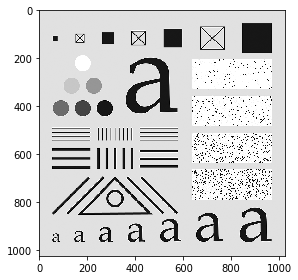

In [3]:
"""Problem 3"""
pattern = read_and_convert("./testpattern1024.tif")
io.imshow(pattern)

In [4]:
def pad_image(im, mode='zeros'):
    H, W = im.shape
    padded = np.zeros((2*H, 2*W))
    for i in range(H):
        for j in range(W):
            if mode == 'zeros':
                padded[i,j] = im[i,j]
            elif mode == 'mirror':
                padded[i,j] = im[i,j]
                padded[i+H,j+W] = im[-i,-j]
                padded[i,j+W] = im[i,-j]
                padded[i+H,j] = im[-i,j]      
    return padded

def filter_in_feq_domain(im, kernel, padding='zeros'):
    fft = np.fft.fft2(im)
    shifted = np.fft.fftshift(fft)
    filtered = np.fft.ifftshift(shifted * kernel)
    inverse = np.fft.ifft2(filtered)
    return np.real(inverse) + np.imag(inverse), 0, 0


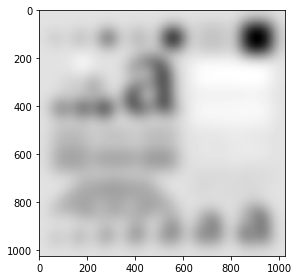

In [5]:
"""(a)"""
def GassuainLowPath(image, sigma, padding_mode='zeros'):
    im = pad_image(image, padding_mode)
    H, W = im.shape
    indices = np.indices((H, W))
    dist_sqaure = (indices[0]-H/2)**2+(indices[1]-W/2)**2
    kernel = np.exp(-dist_sqaure/(2*(sigma**2)))
    filtered_image, dft, filtered_dft = filter_in_feq_domain(im.copy(), kernel)
    return kernel, filtered_image, dft, filtered_dft

sigma = 10
H, W = pattern.shape
kernel, blurred, _, _ = GassuainLowPath(pattern, sigma, padding_mode='mirror')
blurred = blurred[:H, :W]
blurred = normalize(blurred)
io.imshow(blurred)

In [6]:
"""(b)"""
def ButterWorthLowPath(image, cut_off_freq, n, to_float=False, padding_mode='zeros'):
    im = pad_image(image, padding_mode)
    H, W = im.shape
    indices = np.indices((H, W))
    dist = np.sqrt((indices[0]-H/2)**2+(indices[1]-W/2)**2)
    kernel = 1/(1+(dist/cut_off_freq)**(2*n))
    filtered_image, dft, filtered_dft = filter_in_feq_domain(im.copy(), kernel)
    return kernel, filtered_image, dft, filtered_dft 
    
cut_off_freq = 15
order = 2.25
H, W = pattern.shape
kernel, filtered, dft, filtered_dft = ButterWorthLowPath(pattern.copy(), cut_off_freq, order, padding_mode='mirror')
filtered = filtered[:H, :W]

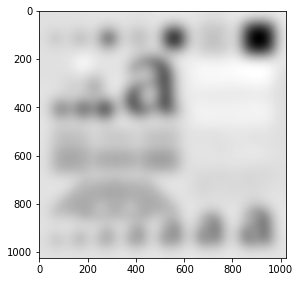

In [7]:
fig=plt.figure(figsize=(10, 10))
# fig.add_subplot(2, 2, 1)
# plt.imshow(kernel, cmap='gray')
fig.add_subplot(2, 2, 2)
plt.imshow(filtered, cmap='gray')
# fig.add_subplot(2, 2, 3)
# plt.imshow(dft, cmap='gray')
# fig.add_subplot(2, 2, 4)
# plt.imshow(filtered_dft, cmap='gray')
plt.show()

/Users/vioichigo/opt/anaconda3/envs/mjrl-env/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


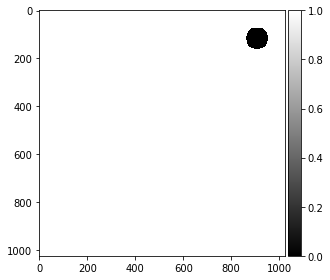

In [8]:
threshold = 0.75
thresholded = ((1.-filtered.copy())>threshold)
"""scaled as said in the textbook, binary threshold"""
io.imshow(1.-thresholded, cmap='gray')

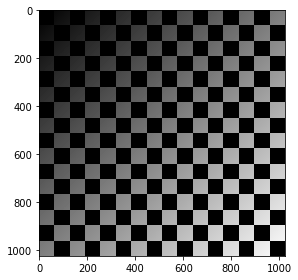

In [9]:
"""(c)"""
checker = read_and_convert('./checkerboard1024-shaded.tif')
io.imshow(checker)

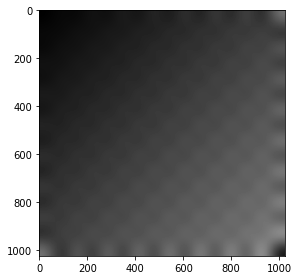

In [10]:
cut_off_freq = 12
order = 3
_, filtered_checker, _, _ = ButterWorthLowPath(checker.copy(), cut_off_freq, order, True, padding_mode='mirror')
H, W = checker.shape
filtered_checker = filtered_checker[:H, :W]
io.imshow(filtered_checker)

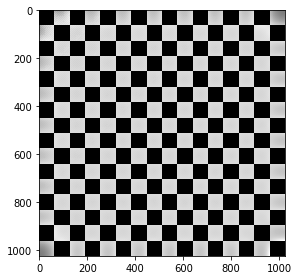

In [11]:
corrected = checker.copy()/filtered_checker.copy()
corrected = normalize(corrected)
io.imshow(corrected,cmap='gray')

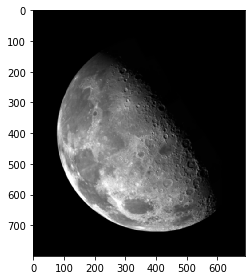

In [12]:
"""Problem 4"""
moon = read_and_convert("./blurry-moon.tif")
io.imshow(moon)

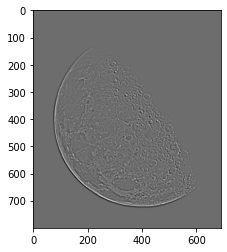

In [47]:
"""(a)"""
def GassuainHighPath(image, sigma, padding_mode='mirror'):
    im = pad_image(image, padding_mode)
    H, W = im.shape
    indices = np.indices((H, W))
    dist_sqaure = (indices[0]-H/2)**2+(indices[1]-W/2)**2
    kernel = 1 - np.exp(-dist_sqaure/(2*(sigma**2)))
    filtered_image, dft, filtered_dft = filter_in_feq_domain(im.copy(), kernel.copy())
    return kernel, filtered_image, dft, filtered_dft

sigma = 100
kernel, details, _, _ = GassuainHighPath(moon, sigma)
H, W = moon.shape
details = details[:H, :W]
plt.imshow(details, cmap='gray')
plt.show()

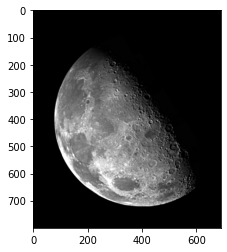

In [51]:
sharpened = moon.copy() + details
sharpened = np.clip(sharpened, 0, 1)
plt.imshow(sharpened, cmap='gray')

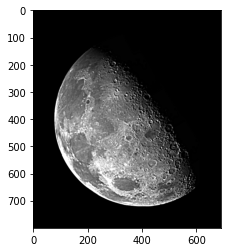

In [50]:
"""(b)"""
k = 3
sharpened = moon.copy() + k*details
# print(sharpened.max(), sharpened.min())
sharpened = np.clip(sharpened, 0, 1)
plt.imshow(sharpened, cmap='gray')

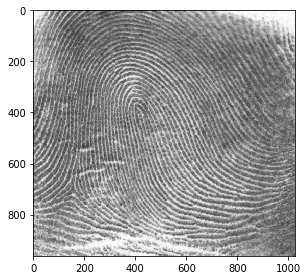

In [16]:
"""Problem 5"""
finger_print = read_and_convert('./Fig0457(a)(thumb_print).tif')
io.imshow(finger_print)

In [27]:
"""(a)"""
def ButterWorthHighPath(image, d, n, to_float=False, padding_mode='mirror'):
    im = pad_image(image, padding_mode)
    H, W = im.shape
    indices = np.indices((H, W))
    dist = np.sqrt((indices[0]-H/2)**2+(indices[1]-W/2)**2) + 1e-8
    kernel = 1/(1+ np.power(cut_off_freq/dist, 2*n))
    filtered_image, dft, filtered_dft = filter_in_feq_domain(im.copy(), kernel)
    return kernel, filtered_image, dft, filtered_dft 
    
cut_off_freq = 50
order = 4
kernel, filtered, dft, filtered_dft = ButterWorthHighPath(finger_print.copy(), cut_off_freq, order, to_float=True)
H, W = finger_print.shape
filtered = filtered[:H, :W]
# filtered = normalize(filtered)

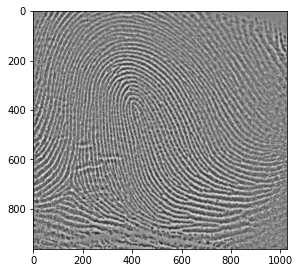

In [28]:
fig=plt.figure(figsize=(10, 10))
fig.add_subplot(2, 2, 2)
plt.imshow(filtered, cmap='gray')
plt.show()

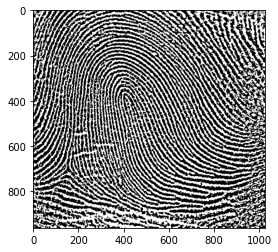

In [41]:
threshold = (filtered>0).astype("uint8")
plt.imshow(threshold, cmap='gray')

In [38]:
"""(b)"""
def laplacianTF4e(im, P, Q):
    H, W = im.shape
    indices = np.indices((H, W))
    kernel = -4*np.pi*((indices[0]-P/2)**2+(indices[1]-Q/2)**2)
    filtered_image, dft, filtered_dft = filter_in_feq_domain(im.copy(), kernel)
    return kernel, filtered_image, dft, filtered_dft 

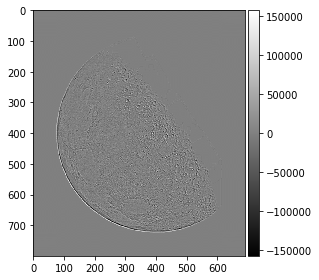

In [44]:
"""(c)"""
def Laplacian(image, padding_mode='mirror'):
    im = pad_image(image, padding_mode)
    H, W = im.shape
    return laplacianTF4e(im, H, W)
   
_, lap, _, _ = Laplacian(moon)
H, W = moon.shape
lap = lap[:H, :W]
io.imshow(lap, cmap='gray')

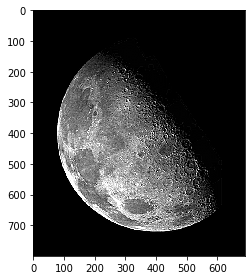

In [45]:
sharpened = moon.copy() - lap/lap.max()
# sharpened = normalize(sharpened)
sharpened = np.clip(sharpened, 0, 1)
io.imshow(sharpened, cmap='gray')

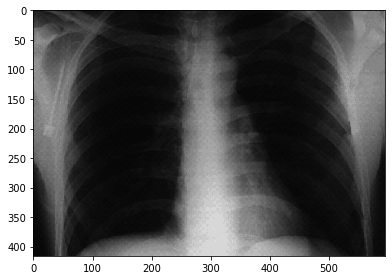

In [34]:
"""(d)"""
chest = read_and_convert('./Fig0459(a)(orig_chest_xray).tif')
io.imshow(chest)

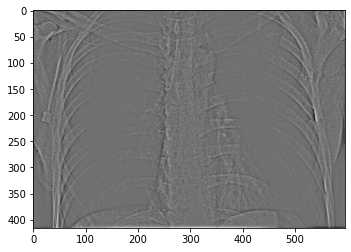

In [35]:
sigma = 60
kernel, details, _, _ = GassuainHighPath(chest, sigma)
H, W = chest.shape
details = details[:H, :W]
details = normalize(details)
plt.imshow(details, cmap='gray')

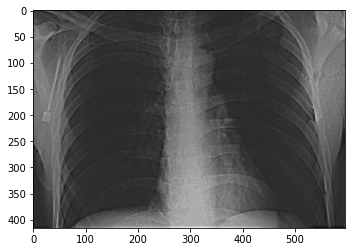

In [36]:
enhanced = details + chest.copy()
enhanced = normalize(enhanced)
enhanced = (enhanced*255).astype("uint8")
plt.imshow(enhanced, cmap='gray')

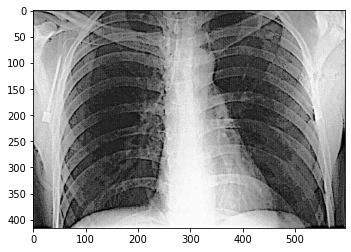

In [37]:
def histEqual4e(f):
    hist, _ = np.histogram(f.flatten(), 256, [0,256])
    cdf = hist.cumsum()
    ref = 255 * cdf / (f.size)
    im = np.zeros(f.shape)
    for i in range(f.shape[0]):
        for j in range(f.shape[1]):
            im[i,j] = ref[f[i,j]]
    return im.astype('uint8')
histogram_equalized = histEqual4e(enhanced)
plt.imshow(histogram_equalized, cmap='gray')